In [1]:
import pandas as pd

In [2]:
import numpy as np
import re

def load_madeira_2019_2021(file_path, sheet_name=0, valid_years=(2019, 2020, 2021)):
    # 1) Ler cru, sem headers (para não herdar lixo)
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

    # 2) Encontrar a linha onde começa a tabela (onde aparece "Culturas")
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx_candidates = col0[col0.str.contains("Culturas", case=False, na=False)].index.tolist()
    if not idx_candidates:
        raise ValueError("Não encontrei a linha com 'Culturas' na 1ª coluna.")
    idx_cult = idx_candidates[0]

    # 3) Encontrar a linha dos anos (2020/2021/2022) nos próximos ~8 rows
    yr_pat = "|".join(str(y) for y in valid_years)
    years_row = None
    for i in range(idx_cult, min(idx_cult + 8, len(raw))):
        row_str = raw.iloc[i].astype(str)
        if row_str.str.contains(yr_pat).any():
            years_row = i
            break
    if years_row is None:
        # fallback: qualquer 4 dígitos
        for i in range(idx_cult, min(idx_cult + 8, len(raw))):
            row_str = raw.iloc[i].astype(str)
            if row_str.str.contains(r"\b\d{4}\b", regex=True).any():
                years_row = i
                break
    if years_row is None:
        raise ValueError("Não encontrei a linha com anos (2020–2022).")

    # 4) A linha de categorias (Superfície/Produção) deve estar logo acima dos anos
    cat_row = max(idx_cult, years_row - 1)

    # 5) Construir nomes de colunas a partir de 2 linhas (categoria + ano), fazendo forward-fill
    cat_vals = raw.iloc[cat_row].copy()
    cat_vals = cat_vals.where(cat_vals.notna()).ffill(axis=0)

    yr_vals = raw.iloc[years_row].copy()
    yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)

    cols = []
    for j in range(raw.shape[1]):
        if j == 0:
            cols.append("Cultura")
        else:
            a = str(cat_vals.iloc[j]).strip()
            b = str(yr_vals.iloc[j]).strip()
            # limpar “ha”, “t”, textos soltos; ficar só com o ano se existir
            b_year = re.search(r"(\d{4})", b)
            b = b_year.group(1) if b_year else b
            # normalizar nomes base
            a = (a.replace("\n", " ")
                   .replace("Superfície", "Superfície")
                   .replace("Produção", "Produção")).strip()
            name = f"{a}_{b}" if (a and b and a.lower() != "nan" and b.lower() != "nan") else (a or b or f"col{j}")
            cols.append(name)

    # 6) Cortar os dados a partir da linha IMEDIATAMENTE abaixo dos anos
    data = raw.iloc[years_row + 1:].reset_index(drop=True)
    data.columns = cols

    # 7) Limpar linhas lixo (títulos de secção, vazios, etc.)
    # manter só linhas com Cultura não nula e que não contenham palavras de cabeçalho
    data = data[~data["Cultura"].isna()]
    data["Cultura"] = data["Cultura"].astype(str).str.strip()
    data = data[~data["Cultura"].str.contains(r"^Anos$|Culturas", case=False, na=False)]
    # remover linhas totalmente vazias nas colunas de valores
    value_cols = [c for c in data.columns if c != "Cultura"]
    data = data.dropna(how="all", subset=value_cols)

    # 8) Manter só colunas úteis (Superfície/Produção para 2020–2022)
    wanted = ["Cultura"]
    for y in valid_years:
        wanted += [f"Superfície_{y}", f"Produção_{y}"]
    # se os nomes vieram ligeiramente diferentes, deixamos em aberto e filtramos por regex
    keep_regex = re.compile(r"^(Superfície|Produção)_(?:%s)$" % "|".join(map(str, valid_years)))
    dyn_keep = ["Cultura"] + [c for c in data.columns if keep_regex.match(c)]
    # preferir os exatos; se não houver, usar os dinâmicos
    keep = [c for c in wanted if c in data.columns]
    if len(keep) < 2:
        keep = dyn_keep
    data = data[keep].copy()

    # 9) Passar para formato longo e extrair Ano/Categoria
    long_df_2019_2021 = data.melt(id_vars="Cultura", var_name="Categoria_Ano", value_name="Valor")
    long_df_2019_2021["Ano"] = long_df_2019_2021["Categoria_Ano"].str.extract(r"(\d{4})").astype(float)
    long_df_2019_2021 = long_df_2019_2021.dropna(subset=["Ano"])
    long_df_2019_2021["Ano"] = long_df_2019_2021["Ano"].astype(int)
    long_df_2019_2021["Categoria"] = long_df_2019_2021["Categoria_Ano"].str.extract(r"^(Superfície|Produção)")

    # 10) Converter Valor para numérico e limpar
    long_df_2019_2021["Valor"] = pd.to_numeric(long_df_2019_2021["Valor"], errors="coerce")
    long_df_2019_2021 = long_df_2019_2021.dropna(subset=["Valor"])
    long_df_2019_2021 = long_df_2019_2021[long_df_2019_2021["Ano"].isin(valid_years)]
    long_df_2019_2021["Cultura"] = long_df_2019_2021["Cultura"].str.strip()

    # 11) Pivot final: Cultura | Ano | Produção | Superfície
    clean = long_df_2019_2021.pivot_table(
        index=["Cultura", "Ano"],
        columns="Categoria",
        values="Valor",
        aggfunc="first"
    ).reset_index()

    # garantir colunas presentes
    for col in ["Superfície", "Produção"]:
        if col not in clean.columns:
            clean[col] = np.nan

    # ordenar e devolver
    clean = clean[["Cultura", "Ano", "Superfície", "Produção"]].sort_values(["Cultura", "Ano"])
    return clean

# === USO ===
df_2019_2021 = load_madeira_2019_2021(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\prod_madeira_2019-2021.xlsx")
print(df_2019_2021.head())


Categoria  Cultura   Ano  Superfície     Produção
0          Abacate  2019      50.394   415.368722
1          Abacate  2020      50.394   461.783317
2          Abacate  2021      50.394   490.101632
3          Abóbora  2019      77.000  1548.407995
4          Abóbora  2020      76.760  1929.477235


C:\Users\sofia\AppData\Local\Temp\ipykernel_22684\2759877672.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)


In [3]:
df_2019_2021.to_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\worked_datasets\prod_madeira_2019_2021.csv", index=False)

In [4]:
import pandas as pd
import numpy as np
import re

def load_madeira_2020_2022(file_path, sheet_name=0, valid_years=(2020, 2021, 2022)):
    # 1) Ler cru, sem headers (para não herdar lixo)
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

    # 2) Encontrar a linha onde começa a tabela (onde aparece "Culturas")
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx_candidates = col0[col0.str.contains("Culturas", case=False, na=False)].index.tolist()
    if not idx_candidates:
        raise ValueError("Não encontrei a linha com 'Culturas' na 1ª coluna.")
    idx_cult = idx_candidates[0]

    # 3) Encontrar a linha dos anos (2020/2021/2022) nos próximos ~8 rows
    yr_pat = "|".join(str(y) for y in valid_years)
    years_row = None
    for i in range(idx_cult, min(idx_cult + 8, len(raw))):
        row_str = raw.iloc[i].astype(str)
        if row_str.str.contains(yr_pat).any():
            years_row = i
            break
    if years_row is None:
        # fallback: qualquer 4 dígitos
        for i in range(idx_cult, min(idx_cult + 8, len(raw))):
            row_str = raw.iloc[i].astype(str)
            if row_str.str.contains(r"\b\d{4}\b", regex=True).any():
                years_row = i
                break
    if years_row is None:
        raise ValueError("Não encontrei a linha com anos (2020–2022).")

    # 4) A linha de categorias (Superfície/Produção) deve estar logo acima dos anos
    cat_row = max(idx_cult, years_row - 1)

    # 5) Construir nomes de colunas a partir de 2 linhas (categoria + ano), fazendo forward-fill
    cat_vals = raw.iloc[cat_row].copy()
    cat_vals = cat_vals.where(cat_vals.notna()).ffill(axis=0)

    yr_vals = raw.iloc[years_row].copy()
    yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)

    cols = []
    for j in range(raw.shape[1]):
        if j == 0:
            cols.append("Cultura")
        else:
            a = str(cat_vals.iloc[j]).strip()
            b = str(yr_vals.iloc[j]).strip()
            # limpar “ha”, “t”, textos soltos; ficar só com o ano se existir
            b_year = re.search(r"(\d{4})", b)
            b = b_year.group(1) if b_year else b
            # normalizar nomes base
            a = (a.replace("\n", " ")
                   .replace("Superfície", "Superfície")
                   .replace("Produção", "Produção")).strip()
            name = f"{a}_{b}" if (a and b and a.lower() != "nan" and b.lower() != "nan") else (a or b or f"col{j}")
            cols.append(name)

    # 6) Cortar os dados a partir da linha IMEDIATAMENTE abaixo dos anos
    data = raw.iloc[years_row + 1:].reset_index(drop=True)
    data.columns = cols

    # 7) Limpar linhas lixo (títulos de secção, vazios, etc.)
    # manter só linhas com Cultura não nula e que não contenham palavras de cabeçalho
    data = data[~data["Cultura"].isna()]
    data["Cultura"] = data["Cultura"].astype(str).str.strip()
    data = data[~data["Cultura"].str.contains(r"^Anos$|Culturas", case=False, na=False)]
    # remover linhas totalmente vazias nas colunas de valores
    value_cols = [c for c in data.columns if c != "Cultura"]
    data = data.dropna(how="all", subset=value_cols)

    # 8) Manter só colunas úteis (Superfície/Produção para 2020–2022)
    wanted = ["Cultura"]
    for y in valid_years:
        wanted += [f"Superfície_{y}", f"Produção_{y}"]
    # se os nomes vieram ligeiramente diferentes, deixamos em aberto e filtramos por regex
    keep_regex = re.compile(r"^(Superfície|Produção)_(?:%s)$" % "|".join(map(str, valid_years)))
    dyn_keep = ["Cultura"] + [c for c in data.columns if keep_regex.match(c)]
    # preferir os exatos; se não houver, usar os dinâmicos
    keep = [c for c in wanted if c in data.columns]
    if len(keep) < 2:
        keep = dyn_keep
    data = data[keep].copy()

    # 9) Passar para formato longo e extrair Ano/Categoria
    long_df_2020_2022 = data.melt(id_vars="Cultura", var_name="Categoria_Ano", value_name="Valor")
    long_df_2020_2022["Ano"] = long_df_2020_2022["Categoria_Ano"].str.extract(r"(\d{4})").astype(float)
    long_df_2020_2022 = long_df_2020_2022.dropna(subset=["Ano"])
    long_df_2020_2022["Ano"] = long_df_2020_2022["Ano"].astype(int)
    long_df_2020_2022["Categoria"] = long_df_2020_2022["Categoria_Ano"].str.extract(r"^(Superfície|Produção)")

    # 10) Converter Valor para numérico e limpar
    long_df_2020_2022["Valor"] = pd.to_numeric(long_df_2020_2022["Valor"], errors="coerce")
    long_df_2020_2022 = long_df_2020_2022.dropna(subset=["Valor"])
    long_df_2020_2022 = long_df_2020_2022[long_df_2020_2022["Ano"].isin(valid_years)]
    long_df_2020_2022["Cultura"] = long_df_2020_2022["Cultura"].str.strip()

    # 11) Pivot final: Cultura | Ano | Produção | Superfície
    clean = long_df_2020_2022.pivot_table(
        index=["Cultura", "Ano"],
        columns="Categoria",
        values="Valor",
        aggfunc="first"
    ).reset_index()

    # garantir colunas presentes
    for col in ["Superfície", "Produção"]:
        if col not in clean.columns:
            clean[col] = np.nan

    # ordenar e devolver
    clean = clean[["Cultura", "Ano", "Superfície", "Produção"]].sort_values(["Cultura", "Ano"])
    return clean

# === USO ===
df_2020_2022 = load_madeira_2020_2022(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\prod_madeira_2020-2022.xlsx")
print(df_2020_2022.head())


Categoria  Cultura   Ano  Superfície  Produção
0          Abacate  2020          50       462
1          Abacate  2021          50       490
2          Abacate  2022          51       498
3          Abóbora  2020          77      1929
4          Abóbora  2021          77      1891


C:\Users\sofia\AppData\Local\Temp\ipykernel_22684\2603096848.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)


In [5]:
df_2020_2022.isna().sum()

Categoria
Cultura       0
Ano           0
Superfície    0
Produção      0
dtype: int64

In [6]:
def load_madeira_2021_2023(file_path, sheet_name=0, valid_years=(2021, 2022, 2023)):
    # 1) Ler cru, sem headers (para não herdar lixo)
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

    # 2) Encontrar a linha onde começa a tabela (onde aparece "Culturas")
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx_candidates = col0[col0.str.contains("Culturas", case=False, na=False)].index.tolist()
    if not idx_candidates:
        raise ValueError("Não encontrei a linha com 'Culturas' na 1ª coluna.")
    idx_cult = idx_candidates[0]

    # 3) Encontrar a linha dos anos (2020/2021/2022) nos próximos ~8 rows
    yr_pat = "|".join(str(y) for y in valid_years)
    years_row = None
    for i in range(idx_cult, min(idx_cult + 8, len(raw))):
        row_str = raw.iloc[i].astype(str)
        if row_str.str.contains(yr_pat).any():
            years_row = i
            break
    if years_row is None:
        # fallback: qualquer 4 dígitos
        for i in range(idx_cult, min(idx_cult + 8, len(raw))):
            row_str = raw.iloc[i].astype(str)
            if row_str.str.contains(r"\b\d{4}\b", regex=True).any():
                years_row = i
                break
    if years_row is None:
        raise ValueError("Não encontrei a linha com anos (2021–2023).")

    # 4) A linha de categorias (Superfície/Produção) deve estar logo acima dos anos
    cat_row = max(idx_cult, years_row - 1)

    # 5) Construir nomes de colunas a partir de 2 linhas (categoria + ano), fazendo forward-fill
    cat_vals = raw.iloc[cat_row].copy()
    cat_vals = cat_vals.where(cat_vals.notna()).ffill(axis=0)

    yr_vals = raw.iloc[years_row].copy()
    yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)

    cols = []
    for j in range(raw.shape[1]):
        if j == 0:
            cols.append("Cultura")
        else:
            a = str(cat_vals.iloc[j]).strip()
            b = str(yr_vals.iloc[j]).strip()
            # limpar “ha”, “t”, textos soltos; ficar só com o ano se existir
            b_year = re.search(r"(\d{4})", b)
            b = b_year.group(1) if b_year else b
            # normalizar nomes base
            a = (a.replace("\n", " ")
                   .replace("Superfície", "Superfície")
                   .replace("Produção", "Produção")).strip()
            name = f"{a}_{b}" if (a and b and a.lower() != "nan" and b.lower() != "nan") else (a or b or f"col{j}")
            cols.append(name)

    # 6) Cortar os dados a partir da linha IMEDIATAMENTE abaixo dos anos
    data = raw.iloc[years_row + 1:].reset_index(drop=True)
    data.columns = cols

    # 7) Limpar linhas lixo (títulos de secção, vazios, etc.)
    # manter só linhas com Cultura não nula e que não contenham palavras de cabeçalho
    data = data[~data["Cultura"].isna()]
    data["Cultura"] = data["Cultura"].astype(str).str.strip()
    data = data[~data["Cultura"].str.contains(r"^Anos$|Culturas", case=False, na=False)]
    # remover linhas totalmente vazias nas colunas de valores
    value_cols = [c for c in data.columns if c != "Cultura"]
    data = data.dropna(how="all", subset=value_cols)

    # 8) Manter só colunas úteis (Superfície/Produção para 2020–2022)
    wanted = ["Cultura"]
    for y in valid_years:
        wanted += [f"Superfície_{y}", f"Produção_{y}"]
    # se os nomes vieram ligeiramente diferentes, deixamos em aberto e filtramos por regex
    keep_regex = re.compile(r"^(Superfície|Produção)_(?:%s)$" % "|".join(map(str, valid_years)))
    dyn_keep = ["Cultura"] + [c for c in data.columns if keep_regex.match(c)]
    # preferir os exatos; se não houver, usar os dinâmicos
    keep = [c for c in wanted if c in data.columns]
    if len(keep) < 2:
        keep = dyn_keep
    data = data[keep].copy()

    # 9) Passar para formato longo e extrair Ano/Categoria
    long_df_2021_2023 = data.melt(id_vars="Cultura", var_name="Categoria_Ano", value_name="Valor")
    long_df_2021_2023["Ano"] = long_df_2021_2023["Categoria_Ano"].str.extract(r"(\d{4})").astype(float)
    long_df_2021_2023 = long_df_2021_2023.dropna(subset=["Ano"])
    long_df_2021_2023["Ano"] = long_df_2021_2023["Ano"].astype(int)
    long_df_2021_2023["Categoria"] = long_df_2021_2023["Categoria_Ano"].str.extract(r"^(Superfície|Produção)")

    # 10) Converter Valor para numérico e limpar
    long_df_2021_2023["Valor"] = pd.to_numeric(long_df_2021_2023["Valor"], errors="coerce")
    long_df_2021_2023 = long_df_2021_2023.dropna(subset=["Valor"])
    long_df_2021_2023 = long_df_2021_2023[long_df_2021_2023["Ano"].isin(valid_years)]
    long_df_2021_2023["Cultura"] = long_df_2021_2023["Cultura"].str.strip()

    # 11) Pivot final: Cultura | Ano | Produção | Superfície
    clean = long_df_2021_2023.pivot_table(
        index=["Cultura", "Ano"],
        columns="Categoria",
        values="Valor",
        aggfunc="first"
    ).reset_index()

    # garantir colunas presentes
    for col in ["Superfície", "Produção"]:
        if col not in clean.columns:
            clean[col] = np.nan

    # ordenar e devolver
    clean = clean[["Cultura", "Ano", "Superfície", "Produção"]].sort_values(["Cultura", "Ano"])
    return clean

# === USO ===
df_2021_2023 = load_madeira_2021_2023(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\prod_madeira_2021-2023.xlsx")
print(df_2021_2023.head())


Categoria  Cultura   Ano  Superfície     Produção
0          Abacate  2021   50.394000   490.101632
1          Abacate  2022   51.153123   497.788794
2          Abacate  2023   51.153123   475.000000
3          Abóbora  2021   76.760000  1890.887690
4          Abóbora  2022   76.760000  1890.887690


C:\Users\sofia\AppData\Local\Temp\ipykernel_22684\1534830527.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)


In [7]:
def load_madeira_2022_2024(file_path, sheet_name=0, valid_years=(2022, 2023, 2024)):
    # 1) Ler cru, sem headers (para não herdar lixo)
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

    # 2) Encontrar a linha onde começa a tabela (onde aparece "Culturas")
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx_candidates = col0[col0.str.contains("Culturas", case=False, na=False)].index.tolist()
    if not idx_candidates:
        raise ValueError("Não encontrei a linha com 'Culturas' na 1ª coluna.")
    idx_cult = idx_candidates[0]

    # 3) Encontrar a linha dos anos (2022/2023/2024) nos próximos ~8 rows
    yr_pat = "|".join(str(y) for y in valid_years)
    years_row = None
    for i in range(idx_cult, min(idx_cult + 8, len(raw))):
        row_str = raw.iloc[i].astype(str)
        if row_str.str.contains(yr_pat).any():
            years_row = i
            break
    if years_row is None:
        # fallback: qualquer 4 dígitos
        for i in range(idx_cult, min(idx_cult + 8, len(raw))):
            row_str = raw.iloc[i].astype(str)
            if row_str.str.contains(r"\b\d{4}\b", regex=True).any():
                years_row = i
                break
    if years_row is None:
        raise ValueError("Não encontrei a linha com anos (2021–2023).")

    # 4) A linha de categorias (Superfície/Produção) deve estar logo acima dos anos
    cat_row = max(idx_cult, years_row - 1)

    # 5) Construir nomes de colunas a partir de 2 linhas (categoria + ano), fazendo forward-fill
    cat_vals = raw.iloc[cat_row].copy()
    cat_vals = cat_vals.where(cat_vals.notna()).ffill(axis=0)

    yr_vals = raw.iloc[years_row].copy()
    yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)

    cols = []
    for j in range(raw.shape[1]):
        if j == 0:
            cols.append("Cultura")
        else:
            a = str(cat_vals.iloc[j]).strip()
            b = str(yr_vals.iloc[j]).strip()
            # limpar “ha”, “t”, textos soltos; ficar só com o ano se existir
            b_year = re.search(r"(\d{4})", b)
            b = b_year.group(1) if b_year else b
            # normalizar nomes base
            a = (a.replace("\n", " ")
                   .replace("Superfície", "Superfície")
                   .replace("Produção", "Produção")).strip()
            name = f"{a}_{b}" if (a and b and a.lower() != "nan" and b.lower() != "nan") else (a or b or f"col{j}")
            cols.append(name)

    # 6) Cortar os dados a partir da linha IMEDIATAMENTE abaixo dos anos
    data = raw.iloc[years_row + 1:].reset_index(drop=True)
    data.columns = cols

    # 7) Limpar linhas lixo (títulos de secção, vazios, etc.)
    # manter só linhas com Cultura não nula e que não contenham palavras de cabeçalho
    data = data[~data["Cultura"].isna()]
    data["Cultura"] = data["Cultura"].astype(str).str.strip()
    data = data[~data["Cultura"].str.contains(r"^Anos$|Culturas", case=False, na=False)]
    # remover linhas totalmente vazias nas colunas de valores
    value_cols = [c for c in data.columns if c != "Cultura"]
    data = data.dropna(how="all", subset=value_cols)

    # 8) Manter só colunas úteis (Superfície/Produção para 2020–2022)
    wanted = ["Cultura"]
    for y in valid_years:
        wanted += [f"Superfície_{y}", f"Produção_{y}"]
    # se os nomes vieram ligeiramente diferentes, deixamos em aberto e filtramos por regex
    keep_regex = re.compile(r"^(Superfície|Produção)_(?:%s)$" % "|".join(map(str, valid_years)))
    dyn_keep = ["Cultura"] + [c for c in data.columns if keep_regex.match(c)]
    # preferir os exatos; se não houver, usar os dinâmicos
    keep = [c for c in wanted if c in data.columns]
    if len(keep) < 2:
        keep = dyn_keep
    data = data[keep].copy()

    # 9) Passar para formato longo e extrair Ano/Categoria
    long_df_2022_2024 = data.melt(id_vars="Cultura", var_name="Categoria_Ano", value_name="Valor")
    long_df_2022_2024["Ano"] = long_df_2022_2024["Categoria_Ano"].str.extract(r"(\d{4})").astype(float)
    long_df_2022_2024 = long_df_2022_2024.dropna(subset=["Ano"])
    long_df_2022_2024["Ano"] = long_df_2022_2024["Ano"].astype(int)
    long_df_2022_2024["Categoria"] = long_df_2022_2024["Categoria_Ano"].str.extract(r"^(Superfície|Produção)")

    # 10) Converter Valor para numérico e limpar
    long_df_2022_2024["Valor"] = pd.to_numeric(long_df_2022_2024["Valor"], errors="coerce")
    long_df_2022_2024 = long_df_2022_2024.dropna(subset=["Valor"])
    long_df_2022_2024 = long_df_2022_2024[long_df_2022_2024["Ano"].isin(valid_years)]
    long_df_2022_2024["Cultura"] = long_df_2022_2024["Cultura"].str.strip()

    # 11) Pivot final: Cultura | Ano | Produção | Superfície
    clean = long_df_2022_2024.pivot_table(
        index=["Cultura", "Ano"],
        columns="Categoria",
        values="Valor",
        aggfunc="first"
    ).reset_index()

    # garantir colunas presentes
    for col in ["Superfície", "Produção"]:
        if col not in clean.columns:
            clean[col] = np.nan

    # ordenar e devolver
    clean = clean[["Cultura", "Ano", "Superfície", "Produção"]].sort_values(["Cultura", "Ano"])
    return clean

# === USO ===
df_2022_2024 = load_madeira_2022_2024(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\prod_madeira_2022-2024.xlsx")
print(df_2022_2024.head())


Categoria  Cultura   Ano  Superfície     Produção
0          Abacate  2022   51.153123   497.788794
1          Abacate  2023   51.153123   475.000000
2          Abacate  2024   52.000000   463.000000
3          Abóbora  2022   76.760000  1890.887690
4          Abóbora  2023   76.760000  2080.000000


C:\Users\sofia\AppData\Local\Temp\ipykernel_22684\916158901.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yr_vals = yr_vals.where(yr_vals.notna()).ffill(axis=0)


In [8]:

dfs = [df_2019_2021, df_2020_2022, df_2021_2023, df_2022_2024] 

# Juntar tudo
df_all = pd.concat(dfs, ignore_index=True)

# Se houver duplicados (porque anos se sobrepõem), remover
df_all = df_all.drop_duplicates(subset=["Cultura","Ano"])

# Ordenar
df_all = df_all.sort_values(by=["Cultura","Ano"]).reset_index(drop=True)

print(df_all.head(20))

Categoria  Cultura   Ano  Superfície     Produção
0          Abacate  2019   50.394000   415.368722
1          Abacate  2020   50.394000   461.783317
2          Abacate  2021   50.394000   490.101632
3          Abacate  2022   51.000000   498.000000
4          Abacate  2023   51.153123   475.000000
5          Abacate  2024   52.000000   463.000000
6          Abóbora  2019   77.000000  1548.407995
7          Abóbora  2020   76.760000  1929.477235
8          Abóbora  2021   76.760000  1890.887690
9          Abóbora  2022   77.000000  1891.000000
10         Abóbora  2023   76.760000  2080.000000
11         Abóbora  2024   80.000000  2059.000000
12          Alface  2019   49.050000  1494.835047
13          Alface  2020   49.050000  1554.628449
14          Alface  2021   49.000000  1477.250000
15          Alface  2022   47.000000  1507.000000
16          Alface  2023   49.000000  1808.000000
17          Alface  2024   51.000000  2079.000000
18          Ameixa  2019   49.512200   412.883003


In [9]:
df_all.shape

(206, 4)

In [10]:
df_all.to_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\worked_datasets\prod_madeira_2019_2024.csv", index=False)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

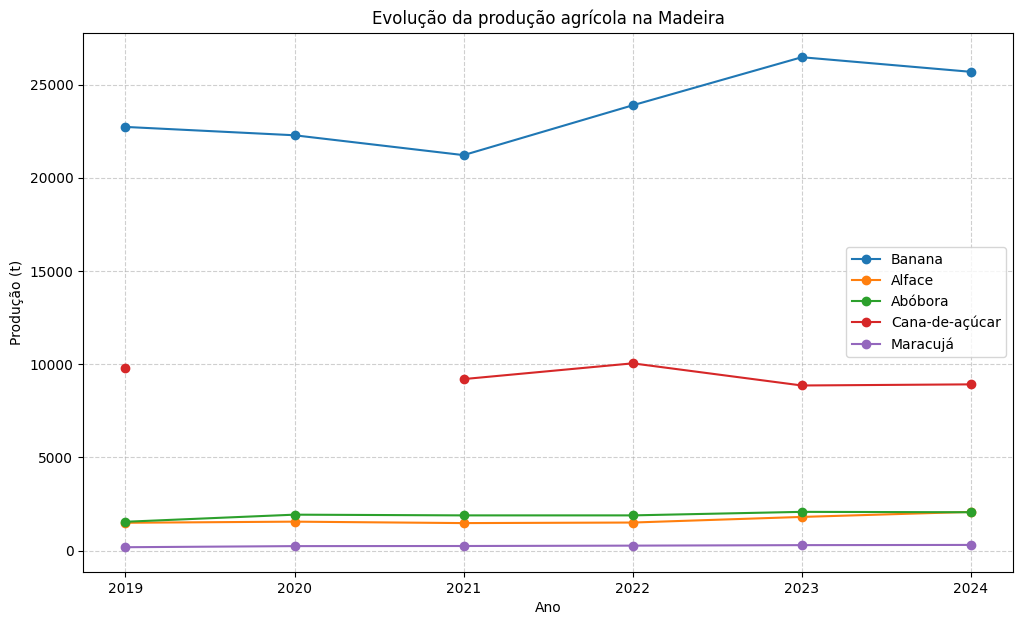

In [12]:
plt.figure(figsize=(12,7))

for cultura in ["Banana","Alface","Abóbora", "Cana-de-açúcar", "Maracujá"]: 
    subset = df_all[df_all["Cultura"].str.contains(cultura, case=False)]
    plt.plot(subset["Ano"], subset["Produção"], marker="o", label=cultura)

plt.title("Evolução da produção agrícola na Madeira")
plt.xlabel("Ano")
plt.ylabel("Produção (t)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

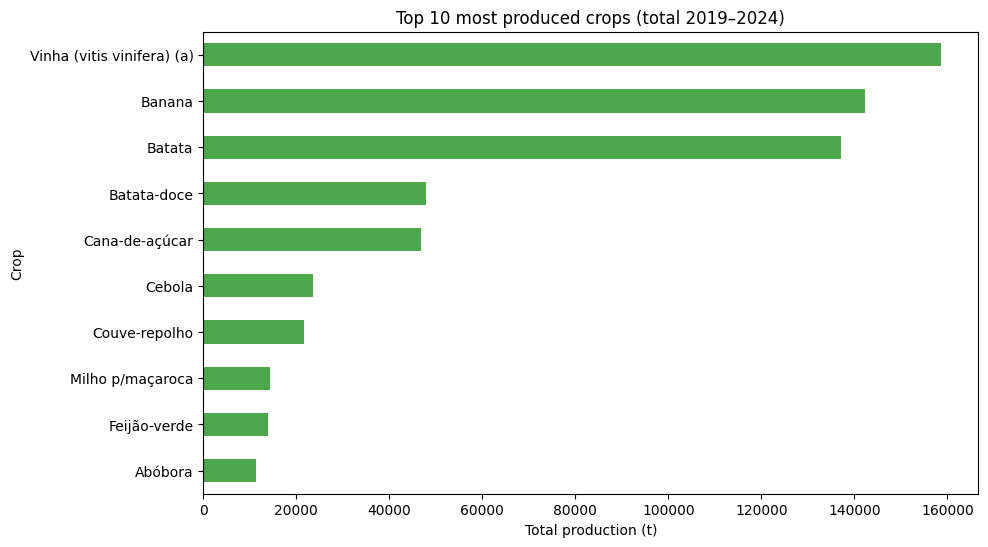

In [13]:
# calcular produção total por cultura
top10 = df_all.groupby("Cultura")["Produção"].sum().nlargest(10)

# gráfico de barras
plt.figure(figsize=(10,6))
top10.sort_values().plot(kind="barh", color="green", alpha=0.7)

plt.title("Top 10 most produced crops (total 2019–2024)")
plt.xlabel("Total production (t)")
plt.ylabel("Crop")
plt.show()

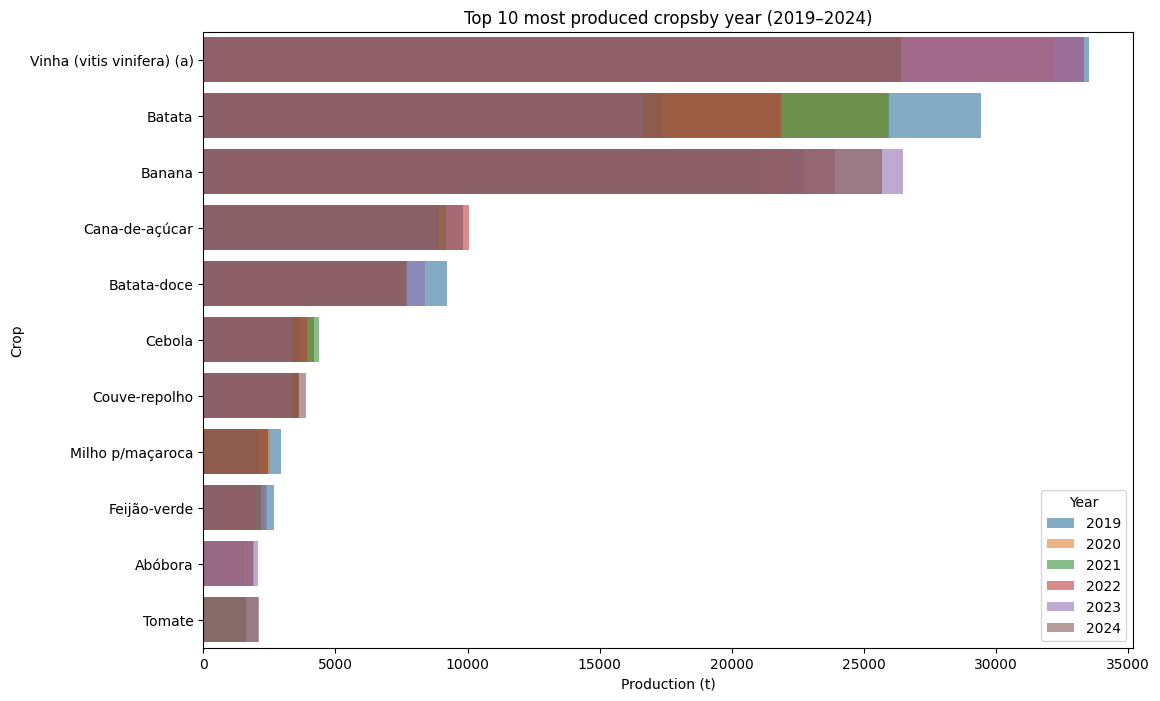

In [14]:
import seaborn as sns

plt.figure(figsize=(12,8))

# ordenar por produção decrescente em cada ano e só manter top 10
for ano, group in df_all.groupby("Ano"):
    top10_ano = group.nlargest(10, "Produção")
    sns.barplot(x="Produção", y="Cultura", data=top10_ano, label=ano, alpha=0.6)

plt.title("Top 10 most produced cropsby year (2019–2024)")
plt.xlabel("Production (t)")
plt.ylabel("Crop")
plt.legend(title="Year")
plt.show()

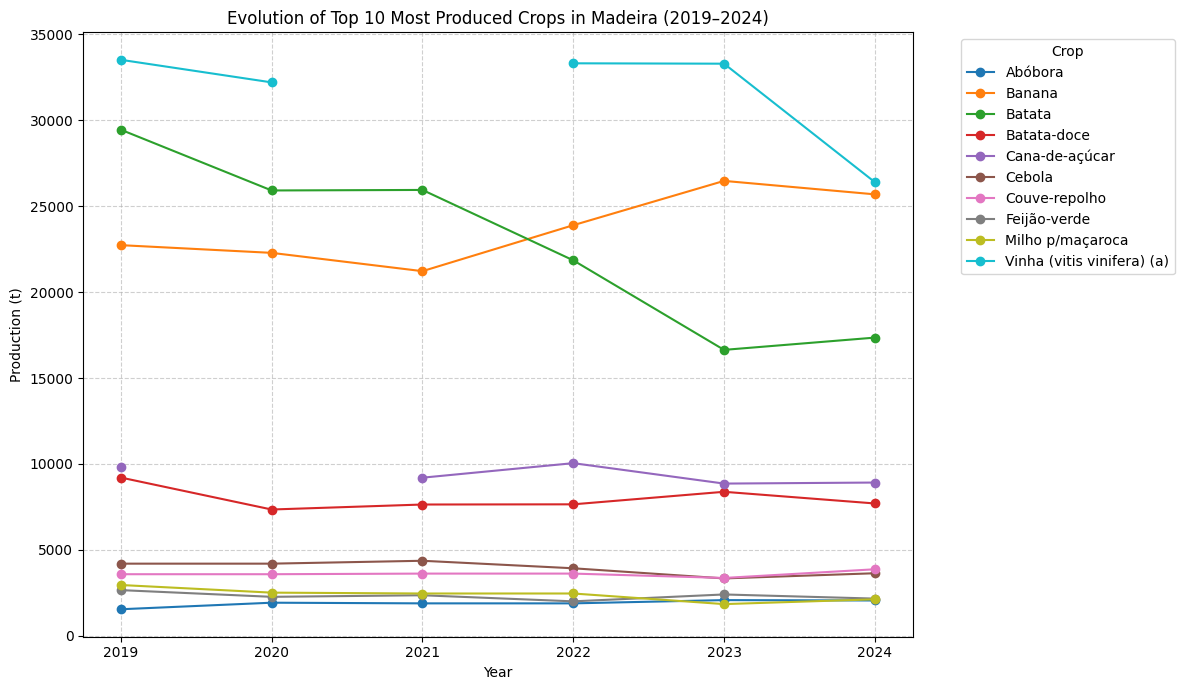

In [15]:
import matplotlib.pyplot as plt

# 1. descobrir as 10 culturas com maior produção acumulada
top10_culturas = (
    df_all.groupby("Cultura")["Produção"]
    .sum()
    .nlargest(10)
    .index
)

# 2. filtrar só essas culturas
df_top10 = df_all[df_all["Cultura"].isin(top10_culturas)]

# 3. gráfico de linhas
plt.figure(figsize=(12,7))

for cultura in df_top10["Cultura"].unique():
    subset = df_top10[df_top10["Cultura"] == cultura]
    plt.plot(subset["Ano"], subset["Produção"], marker="o", label=cultura)

plt.title("Evolution of Top 10 Most Produced Crops in Madeira (2019–2024)")
plt.xlabel("Year")
plt.ylabel("Production (t)")
plt.legend(title="Crop", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [16]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [18]:
import plotly.express as px
import plotly.graph_objects as go


# 1. descobrir as 10 culturas mais produzidas no total
top10_culturas = (
    df_all.groupby("Cultura")["Produção"]
    .sum()
    .nlargest(10)
    .index
)

# 2. filtrar só essas culturas
df_top10 = df_all[df_all["Cultura"].isin(top10_culturas)]

# 3. gráfico interativo
fig = px.line(
    df_top10,
    x="Ano",
    y="Produção",
    color="Cultura",
    markers=True,
    title="Evolução das 10 culturas mais produzidas"
)

# layout mais limpo
fig.update_layout(
    xaxis_title="Ano",
    yaxis_title="Produção (t)",
    legend_title="Cultura",
    template="plotly_white"
)

fig.show()


In [19]:
import plotly.graph_objects as go


# 1. descobrir as 10 culturas mais produzidas no total
top10_culturas = (
    df_all.groupby("Cultura")["Superfície"]
    .sum()
    .nlargest(10)
    .index
)

# 2. filtrar só essas culturas
df_top10 = df_all[df_all["Cultura"].isin(top10_culturas)]

# 3. gráfico interativo
fig = px.line(
    df_top10,
    x="Ano",
    y="Superfície",
    color="Cultura",
    markers=True,
    title="Evolution of Top 10 Crops with the most area in Madeira (2019–2024)"
)

# layout mais limpo
fig.update_layout(
    xaxis_title="Ano",
    yaxis_title="Superfície (ha)",
    legend_title="Cultura",
    template="plotly_white"
)

fig.show()

Prices in the producer

In [20]:
import pandas as pd

# 1) Ler o ficheiro já limpo
df = pd.read_excel(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\preco_no_produtor.xlsx")

# 2) Transformar de wide (anos em colunas) → long (anos em linhas)
df_long_crops = df.melt(
    id_vars=["categoria", "produtos_agricolas", "unidade"],
    var_name="Ano",
    value_name="Preco"
)

# 3) Conversões
df_long_crops["Ano"] = df_long_crops["Ano"].astype(int)
df_long_crops["Preco"] = pd.to_numeric(
    df_long_crops["Preco"].astype(str).str.replace(",", ".", regex=False),
    errors="coerce"
)

# 4) Ver resultado
print(df_long_crops.head())
print(df_long_crops.shape)




                        categoria produtos_agricolas      unidade   Ano  \
0             Plantas Industriais     Cana-de-açúcar  Euro/100 kg  2010   
1  Vegetais e Produtos Hortícolas             Alface  Euro/100 kg  2010   
2  Vegetais e Produtos Hortícolas      Couve repolho  Euro/100 kg  2010   
3  Vegetais e Produtos Hortícolas            Tomate   Euro/100 kg  2010   
4  Vegetais e Produtos Hortícolas            Cenoura  Euro/100 kg  2010   

    Preco  
0   25.00  
1  206.53  
2   65.01  
3  114.38  
4  117.68  
(555, 5)


In [21]:
df_long_crops.to_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\worked_datasets\preco_no_produtor.csv", index=False)

In [22]:
df_long_crops.shape

(555, 5)

In [23]:
df_long_crops.value_counts()

categoria                       produtos_agricolas       unidade      Ano   Preco  
Batata de consumo               Batata de conservação    Euro/100 kg  2010  63.17      1
Vegetais e Produtos Hortícolas  Acelga                   Euro/100 kg  2022  64.19      1
                                                                      2016  62.57      1
                                                                      2017  58.43      1
                                                                      2018  69.67      1
                                                                                      ..
Outros produtos vegetais        Batata-doce              Euro/100 kg  2010  184.05     1
Mel                             Mel                      Euro/100 kg  2024  650.00     1
                                                                      2023  600.00     1
                                                                      2022  600.00     1
Vinhos                    

In [24]:
print(df_long_crops["produtos_agricolas"].nunique())
print(df_long_crops["produtos_agricolas"].unique()[:20]) 

37
['Cana-de-açúcar' 'Alface' 'Couve repolho' 'Tomate ' 'Cenoura'
 'Feijão verde' 'Cebola' 'Pepino' 'Pimento' 'Courgette' 'Nabo' 'Abóbora'
 'Acelga' 'Pimpinela' 'Rosa' 'Cravo' 'Gerbera' 'Estrelícia' 'Antúrio'
 'Orquídea']


In [25]:
df_long_crops.head(20)

,categoria,produtos_agricolas,unidade,Ano,Preco
0,Plantas Industriais,Cana-de-açúcar,Euro/100 kg,2010,25.00
1,Vegetais e Produtos Hortícolas,Alface,Euro/100 kg,2010,206.53
2,Vegetais e Produtos Hortícolas,Couve repolho,Euro/100 kg,2010,65.01
3,Vegetais e Produtos Hortícolas,Tomate,Euro/100 kg,2010,114.38
4,Vegetais e Produtos Hortícolas,Cenoura,Euro/100 kg,2010,117.68
5,Vegetais e Produtos Hortícolas,Feijão verde,Euro/100 kg,2010,203.57
6,Vegetais e Produtos Hortícolas,Cebola,Euro/100 kg,2010,122.53
7,Vegetais e Produtos Hortícolas,Pepino,Euro/100 kg,2010,281.23
8,Vegetais e Produtos Hortícolas,Pimento,Euro/100 kg,2010,112.29
9,Vegetais e Produtos Hortícolas,Courgette,Euro/100 kg,2010,103.00


In [33]:
df_long_crops.to_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\worked_datasets\preco_no_produtor.csv", index=False)

In [35]:
df_long_crops_copy = df_long_crops.copy()

In [26]:
import plotly.express as px

# 1. descobrir as 10 culturas com preços médios mais altos
top10_crops = (
    df_long_crops.groupby("produtos_agricolas")["Preco"]
    .mean()
    .nlargest(10)
    .index
)

# 2. filtrar só essas culturas
df_top10_prices = df_long_crops[df_long_crops["produtos_agricolas"].isin(top10_crops)].copy()

# garantir que Ano é inteiro
df_top10_prices["Ano"] = df_top10_prices["Ano"].astype(int)

# 3. gráfico interativo
fig = px.line(
    df_top10_prices,
    x="Ano",
    y="Preco",
    color="produtos_agricolas",
    markers=True,
    title="Evolution of Top 10 Most Expensive Crops in Madeira (2010–2024)"
)

# layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Prices (€/100kg or €/hL or €/100 units)",
    legend_title="Crops",
    template="plotly_white"
)

fig.show()


In [27]:
import plotly.express as px

# valores únicos de unidade
unidades = df_long_crops["unidade"].unique()

for unidade in unidades:
    df_sub = df_long_crops[df_long_crops["unidade"] == unidade]

    fig = px.line(
        df_sub,
        x="Ano",
        y="Preco",
        color="produtos_agricolas",
        title=f"Evolution of prices - Unit: {unidade}",
        markers=True
    )

    fig.update_layout(
        xaxis_title="Year",
        yaxis_title=f"Price ({unidade})",
        template="plotly_white",
        legend_title="Product"
    )

    fig.show()


Production (in M€)

In [28]:
df_values = pd.read_excel(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\Datasets\Prices_data\producao_vegetal_por_tipo.xlsx") 

df_values = df_values.sort_values(by=["Ano"]).reset_index(drop=True)

In [29]:
df_values.head()

,Ano,Hortícolas frescos,Plantas e flores,Batatas (inclui sementes),Frutos frescos,Citrinos,Frutos subtropicais,Uvas,Vinho,Outros produtos vegetais
0,1995,13.01,3.44,9.96,0.86,0.24,11.40,1.00,7.12,11.22
1,1996,10.95,3.42,9.99,0.92,0.26,12.32,1.07,7.89,11.80
2,1997,12.01,3.46,10.00,0.99,0.24,10.12,1.41,7.18,11.01
3,1998,12.23,5.79,9.97,1.33,0.19,9.62,2.07,6.99,7.47
4,1999,10.57,5.86,21.44,2.48,0.49,5.89,1.94,10.85,4.81


In [30]:
# renomear colunas

df_values.columns = df_values.columns.str.strip().str.replace(" ", "_").str.replace("-", "_").str.lower()

df_values.head()

,ano,hortícolas_frescos,plantas_e_flores,batatas_(inclui_sementes),frutos_frescos,citrinos,frutos_subtropicais,uvas,vinho,outros_produtos_vegetais
0,1995,13.01,3.44,9.96,0.86,0.24,11.40,1.00,7.12,11.22
1,1996,10.95,3.42,9.99,0.92,0.26,12.32,1.07,7.89,11.80
2,1997,12.01,3.46,10.00,0.99,0.24,10.12,1.41,7.18,11.01
3,1998,12.23,5.79,9.97,1.33,0.19,9.62,2.07,6.99,7.47
4,1999,10.57,5.86,21.44,2.48,0.49,5.89,1.94,10.85,4.81


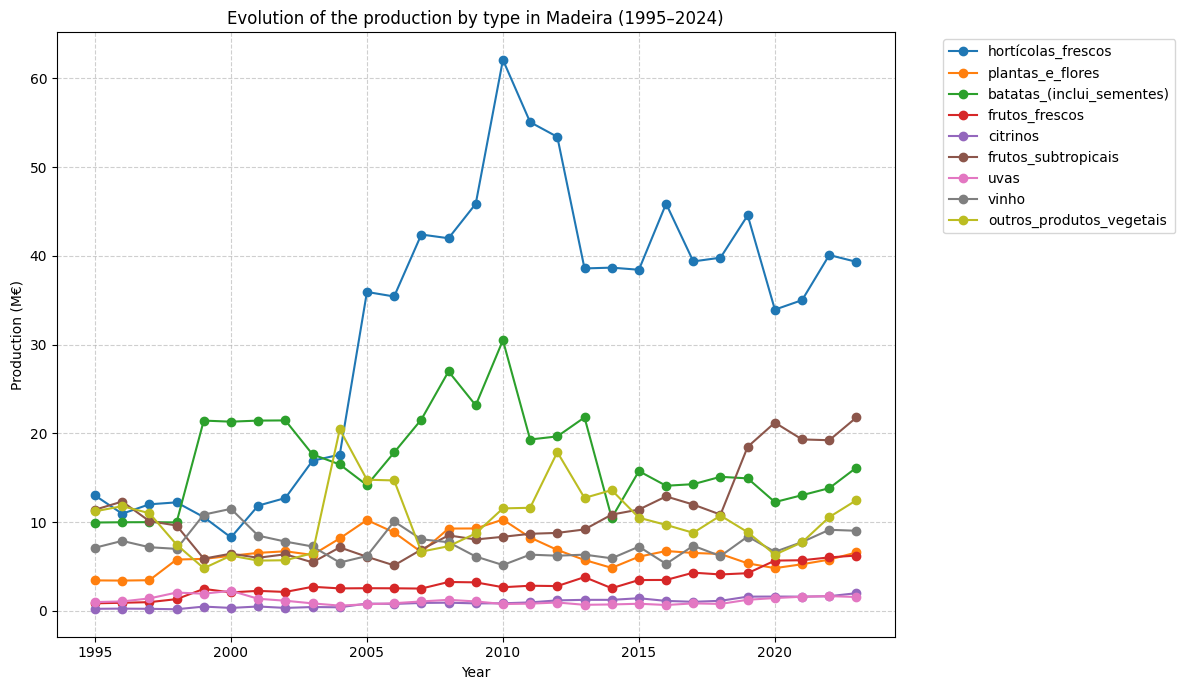

In [37]:
# gráfico de linhas para cada tipo de produção
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
for col in df_values.columns:
    if col != "ano":
        plt.plot(df_values["ano"], df_values[col], marker="o", label=col)
plt.title("Evolution of the production by type in Madeira (1995–2024)")
plt.xlabel("Year")
plt.ylabel("Production (M€)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [34]:
df_values.to_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\ironhack_final_project\worked_datasets\producao_vegetal_por_tipo.csv", index=False)

In [36]:
df_values_copy = df_values.copy()